**Created by Muhammed El-Yamani**

**🚀 Jaws Segmentation Task Atomica**

**12 Jun 2022**


# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [1]:
# ! pip install --user torch torchvision matplotlib numpy progressbar
# %conda install -c conda-forge progressbar

In [2]:
# %conda install -c conda-forge ipywidgets

## Import Libraries

In [3]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

import wandb

import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
import json
from tqdm import tqdm
import logging
from pathlib import Path
from torch.utils.data import Dataset
import re


In [4]:
# helper files
from utils.dice_score import dice_loss
from evaluate import evaluate
from unet import UNet
from utils.utils import plot_test_sample
from net_utility import Net_Utility
from utils.load_dataset import JawsDataset, transform_data_entry, axial_dataset_train, coronal_dataset_train, sagittal_dataset_train, axial_dataset_test, coronal_dataset_test, sagittal_dataset_test


## Global variables

In [5]:
LOCAL_DATASET_PATH = 'dataset'
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

In [6]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 16
CLASSES = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
MULTIPLE_TRAIN_SIZE = 2
PLANES = ['axial', 'coronal', 'sagittal']
LOADER_ARGS = dict(batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# EPOCHS = 5
EPOCHS = 1
LEARNING_RATE = 1e-5
VAL_PERCENT = 0.1
AMP = False
BILINEAR = False
TRAIN = True
logging.getLogger('').setLevel(logging.INFO)
logging.info(f'Using device {DEVICE}')

INFO:root:Using device cuda


## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [7]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

# download_data()

## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in original Data:</u></b><br>
 
* <i> jaws - labels - int. 0 - 1 - 2</i><br>
* <i> upper (Maxilla)  - Label: 1 </i><br>
* <i> lower(Mandible)  - Label: 2 </i><br>
* <i> images: float32  range(-1000, 18000) abroximtly ,more or less</i><br>
* <i> images: square aspect ratio with different sizes</i><br>
* <i>axial training dataset: 5043 slice </i><br>
* <i>coronal training dataset: 7277 slice </i><br>
* <i>sagittal training dataset: 7277 slice </i><br>
* <i>There are holes in the masks, especially in the plane axial. I am not sure whether they are correct or wrong. So I left them as is. </i><br>
</div>

In [8]:
LOCAL_OTUPUT_PATH = 'save_files'
MIN_VAL_LABEL = 0
MAX_VAL_LABEL = 2
BIN_SIZE = 0.1

try:
    with open(f'{LOCAL_OTUPUT_PATH}/labels_dig_{BIN_SIZE}', 'r') as labelsFile:
        plan_dig_dict_sum = dict(json.load(labelsFile))
except Exception:
    planes = ['axial', 'coronal', 'sagittal']
    plan_dig_dict_sum = dict()
    for plane in planes:
        split_dig_dict_sum = dict()
        for split in ['train', 'test']:
            label_dig_dict_sum = dict()
            lbls = glob.glob(
                f'{LOCAL_DATASET_PATH}/{plane}/{split}/**/*.label.npy.gz')
            lbls = sorted(lbls)
            print(f"digtizing for {split} in {plane} labels ...")
            for index, lbl in enumerate(tqdm(lbls)):
                label = gzip.GzipFile(lbl, 'rb')
                label = np.load(label)
                # Convert continuous label in range(0, 2) into digital value
                #  with bin size = BIN_SIZE
                intervals = np.arange(MAX_VAL_LABEL * 10 + 1, step=BIN_SIZE*10)/10
                index = np.digitize(label.reshape(-1), intervals) - 1
                dig_label=intervals[index]
                values, counts = np.unique(dig_label, return_counts=True)
                values = [str(value) for value in values ]
                label_dig_dict = dict(zip(values, counts))
                for value, count in label_dig_dict.items():
                    if value in label_dig_dict_sum:
                        label_dig_dict_sum[value] += count
                    else:
                        label_dig_dict_sum[value] = count
            split_dig_dict_sum[split] = label_dig_dict_sum
        plan_dig_dict_sum[plane] = split_dig_dict_sum

    if os.path.isdir(LOCAL_OTUPUT_PATH) == False:
        os.mkdir(LOCAL_OTUPUT_PATH)
    with open(f'{LOCAL_OTUPUT_PATH}/labels_dig_{BIN_SIZE}', 'w') as labelsFile:
        labelsFile.write(json.loads(json.dumps(
            str(plan_dig_dict_sum))).replace("'", '"'))
    print('Done')


In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.figure(figsize=(14, 6))
subplot_titles = list()
for j, split in enumerate(['train', 'test']):
    for i, plane in enumerate(['axial', 'coronal', 'sagittal']):
        subplot_titles.append(f'{plane}_{split}')
fig = make_subplots(rows=2, cols=3, subplot_titles=subplot_titles,  x_title='Values', y_title='Count')
for j, split in enumerate(['train', 'test']):
    for i, plane in enumerate(['axial', 'coronal', 'sagittal']):
        values = list(plan_dig_dict_sum[plane][split].keys())
        counts = list(plan_dig_dict_sum[plane][split].values())
        data = go.Bar(x=values, y=counts)
        # data = go.Scatter(x=[1, 2, 3], y=[4, 5, 6])
        fig.add_trace(data, row=j + 1, col=i + 1)

fig.update_layout(height=400, width=600, title_text="digital Labels")
fig.show()


<Figure size 1008x432 with 0 Axes>

***

I thought, in the beginning, the masks have some noise. And this is because after resizing the images I found float numbers. But the masks are int and floating as a result of interpolation.
So there is no need to digitize the labels and display them like this.

***


# Preprocessing The Dataset

Transformations:
- labels :
    - Resized NEAREST 
    - tensor 
    - Long
- images
    - Normalized float32 range(0, 1) 
    - resized BICUBIC
    - tensor

## Augmentation

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>After augmantation Data with multiple Xn training size:</u></b><br>
 
* <i>axial training dataset X4: 20172 slice </i><br>
* <i>coronal training dataset X3: 21831 slice </i><br>
* <i>sagittal training dataset X3: 21831 slice </i><br>

To increase the variations in training 
- Transformations
  - Shift invariance
  - Rotation invariance
  - Deformations invariance
  - Gray value invariance
- I think The images for the planes from one side of view, So there is no need for generating new transformations with flipping

Data Augmentation - part 3.1<br> U-Net: Convolutional Networks for Biomedical Image Segmentation


- Tranformation for Trianing [Augmentation]

- Types of Augmentation 
  - Generate new data set over head befor training -> increase the size of data
  - Generate new data set during training (new for each epoch) -> the same size data but need increase number of epochs

References:
- COLORJITTER: https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter
- RANDOMAFFINE: https://pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html#torchvision.transforms.RandomAffine
- RANDOMRESIZEDCROP: https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomResizedCrop.html#torchvision.transforms.RandomResizedCrop


In [10]:
torch.manual_seed(0)
np.random.seed(0)
axial_train_dataset, axial_validation_dataset = axial_dataset_train(
    image_size=IMAGE_SIZE, validation_ratio = VAL_PERCENT, multiple_train_size=MULTIPLE_TRAIN_SIZE)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(
    image_size=IMAGE_SIZE, validation_ratio = VAL_PERCENT, multiple_train_size=MULTIPLE_TRAIN_SIZE)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(
    image_size=IMAGE_SIZE, validation_ratio = VAL_PERCENT, multiple_train_size=MULTIPLE_TRAIN_SIZE)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')


axial training dataset: 10086 slice
coronal training dataset: 14554 slice
sagittal training dataset: 14554 slice


In [11]:
axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, **LOADER_ARGS)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, **LOADER_ARGS)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, **LOADER_ARGS)

In [12]:
axial_validation_loader = torch.utils.data.DataLoader(
    axial_validation_dataset, shuffle=True, **LOADER_ARGS, drop_last=True)
coronal_validation_loader = torch.utils.data.DataLoader(
    coronal_validation_dataset, shuffle=True, **LOADER_ARGS, drop_last=True)
sagittal_validation_loader = torch.utils.data.DataLoader(
    sagittal_validation_dataset, shuffle=True, **LOADER_ARGS, drop_last=True)

In [13]:
train_loaders = dict()
train_loaders["axial"] = axial_train_loader
train_loaders["coronal"] = coronal_train_loader
train_loaders["sagittal"] = sagittal_train_loader

validation_loaders = dict()
validation_loaders["axial"] = axial_validation_loader
validation_loaders["coronal"] = coronal_validation_loader
validation_loaders["sagittal"] = sagittal_validation_loader

In [14]:
n_train_dict = dict()
n_train_dict["axial"] = len(axial_train_dataset)
n_train_dict["coronal"] = len(coronal_train_dataset)
n_train_dict["sagittal"] = len(sagittal_train_dataset)

n_validation_dict = dict()
n_validation_dict["axial"] = len(axial_validation_dataset)
n_validation_dict["coronal"] = len(coronal_validation_dataset)
n_validation_dict["sagittal"] = len(sagittal_validation_dataset)

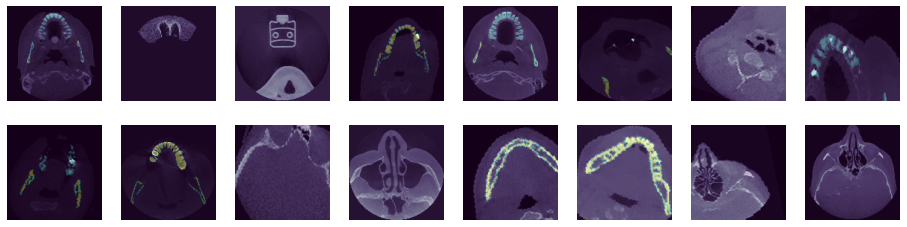

In [15]:
axial_data_iter = iter(axial_train_loader)
batch = axial_data_iter.next()
images, labels = batch['image'], batch['mask']
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
    plt.subplot(2, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='bone')
    plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)


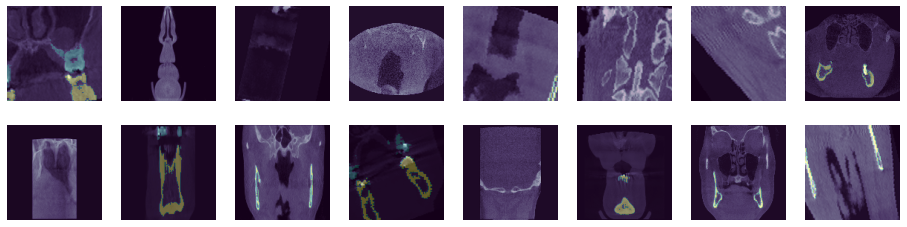

In [16]:
coronal_data_iter = iter(coronal_train_loader)
batch = coronal_data_iter.next()
images, labels = batch['image'], batch['mask']
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

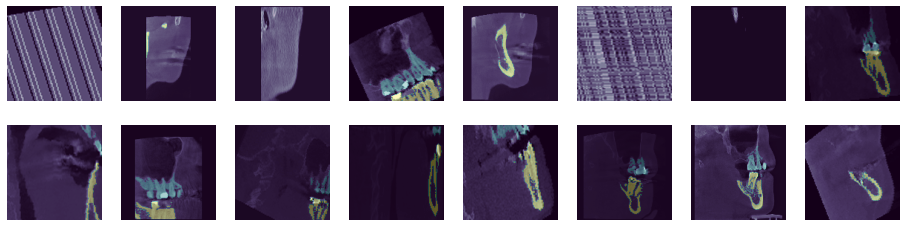

In [17]:
sagittal_data_iter = iter(sagittal_train_loader)
batch = sagittal_data_iter.next()
images, labels = batch['image'], batch['mask']
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

In [13]:
# import gzip
# import numpy as np
# import glob
# from PIL import Image

# files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
# index_occured = []
# for i in range(100):
#     index = np.random.randint(0, len(files))
#     if index in index_occured:
#         i -= 1
#         continue
#     dicom_path = files[index]
#     dicom_file = gzip.GzipFile(dicom_path, 'rb')
#     dicom = np.load(dicom_file)
#     im = Image.fromarray(dicom)
#     im = im.convert('RGB')
#     f = f'output_dataset/img{i + 1}.png'
#     im.save(f)


## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Modeling:</u></b><br>
 
* <i> Choose model: UNET</i><br>
* <i> Prefere to make a single model for each view to get better results</i><br>


### <span style="color:#e76f51;">References</span>

- U-Net: Convolutional Networks for Biomedical Image Segmentation: https://arxiv.org/pdf/1505.04597.pdf

- Pytorch-UNet: https://github.com/milesial/Pytorch-UNet

In [ ]:
net_utility_axial = Net_Utility(plane='axial', train_loaders=train_loaders, validation_loaders=validation_loaders, n_train_dict=n_train_dict, n_validation_dict=n_validation_dict, img_size=IMAGE_SIZE, n_classes=CLASSES,
            save_checkpoint=True, train=TRAIN, load_last_model=False, load_interrupted_model=False, bilinear=BILINEAR, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, val_percent=VAL_PERCENT, amp=AMP)
net_utility_axial.train_plane()


INFO:root:Using device cuda
INFO:root:Network:
	1 input channels
	3 output channels (classes)
	Transposed conv upscaling
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: muhammed-elyamani. Use `wandb login --relogin` to force relogin
2022-06-12 18:33:52.357428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


INFO:root:Starting training:
            Epochs:          1
            plane:     axial
            Batch size:      16
            Learning rate:   1e-05
            Training size:   10086
            Validation size: 561
            Checkpoints:     True
            Device:          cuda
            Images size:  (128, 128)
            Mixed Precision (amp): False
        
Epoch 1/1: 100%|██████████| 10086/10086 [14:37<00:00, 11.50img/s, loss (batch)=0.544]
INFO:root:
                Avg. epoch train loss":    0.7960007967170558
                           
INFO:root:Checkpoint 1 saved!


In [ ]:
net_utility_axial.display_results()

In [ ]:
net_utility_coronal = Net_Utility(plane='coronal', train_loaders=train_loaders, validation_loaders=validation_loaders, n_train_dict=n_train_dict, n_validation_dict=n_validation_dict, img_size=IMAGE_SIZE, n_classes=CLASSES,
            save_checkpoint=True, train=TRAIN, load_last_model=False, load_interrupted_model=False, bilinear=BILINEAR, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, val_percent=VAL_PERCENT, amp=AMP)
net_utility_coronal.train_plane()


INFO:root:Using device cuda
INFO:root:Network:
	1 input channels
	3 output channels (classes)
	Transposed conv upscaling


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,████████▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
validation Dice,▆▄▆▇▅█▆█▁█
epoch,1
learning rate,0.0
step,631
train loss,0.5435
validation Dice,0.51115


2022-06-12 18:48:49.528826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


INFO:root:Starting training:
            Epochs:          1
            plane:     coronal
            Batch size:      16
            Learning rate:   1e-05
            Training size:   14554
            Validation size: 809
            Checkpoints:     True
            Device:          cuda
            Images size:  (128, 128)
            Mixed Precision (amp): False
        
Epoch 1/1: 100%|██████████| 14554/14554 [23:55<00:00, 10.14img/s, loss (batch)=0.192]
INFO:root:
                Avg. epoch train loss":    0.5113323006983642
                           
INFO:root:Checkpoint 1 saved!


In [ ]:
net_utility_coronal.display_results()

In [ ]:
net_utility_sagittal = Net_Utility(plane='sagittal', train_loaders=train_loaders, validation_loaders=validation_loaders, n_train_dict=n_train_dict, n_validation_dict=n_validation_dict, img_size=IMAGE_SIZE, n_classes=CLASSES,
            save_checkpoint=True, train=TRAIN, load_last_model=False, load_interrupted_model=False, bilinear=BILINEAR, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, val_percent=VAL_PERCENT, amp=AMP)
net_utility_sagittal.train_plane()


INFO:root:Using device cuda
INFO:root:Network:
	1 input channels
	3 output channels (classes)
	Transposed conv upscaling


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning rate,████████▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▆▆▅▅▅▄▄▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
validation Dice,▁▄▃▄▇█████
epoch,1
learning rate,0.0
step,910
train loss,0.19223
validation Dice,0.80955


2022-06-12 19:13:04.717809: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


INFO:root:Starting training:
            Epochs:          1
            plane:     sagittal
            Batch size:      16
            Learning rate:   1e-05
            Training size:   14554
            Validation size: 809
            Checkpoints:     True
            Device:          cuda
            Images size:  (128, 128)
            Mixed Precision (amp): False
        
Epoch 1/1: 100%|██████████| 14554/14554 [32:21<00:00,  7.50img/s, loss (batch)=0.251]
INFO:root:
                Avg. epoch train loss":    0.4982230959521545
                           
INFO:root:Checkpoint 1 saved!


In [ ]:
net_utility_sagittal.display_results()

## Testing

Now you should run your trained model on the test dataset available below and report your results

In [ ]:
axial_test_dataset = axial_dataset_test(IMAGE_SIZE)
coronal_test_dataset = coronal_dataset_test(IMAGE_SIZE)
sagittal_test_dataset = sagittal_dataset_test(IMAGE_SIZE)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(
    axial_test_dataset, shuffle=True, **LOADER_ARGS)
coronal_test_loader = torch.utils.data.DataLoader(
    coronal_test_dataset, shuffle=True, **LOADER_ARGS)
sagittal_test_loader = torch.utils.data.DataLoader(
    sagittal_test_dataset, shuffle=True, **LOADER_ARGS)


axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice


In [ ]:
def load_model(plane, load_last_model=False, load_interrupted_model=False, path_checkpont=None):
    check_folders = sorted(os.listdir('checkpoints'))
    nums = sorted([int(re.search(r'[0-9]+', folder).group())
                  for folder in check_folders])
    last_num_check_folders = nums[-1]
    dir_checkpoint = Path(f'./checkpoints/v{last_num_check_folders}/{plane}')

    check_vn_epochs = sorted(os.listdir(dir_checkpoint))
    nums = sorted([int(re.search(r'[0-9]+', folder).group())
                  for folder in check_vn_epochs])
    last_num_check_vn_epochs = nums[-1]

    if path_checkpont is not None:
        load_model = path_checkpont
    elif load_last_model:
        load_model = str(dir_checkpoint) + f'/checkpoint_epoch{last_num_check_vn_epochs}.pth'
    elif load_interrupted_model:
        load_model = str(dir_checkpoint) + f'/INTERRUPTED.pth'
    else:
        load_model = False

    try:
        net = UNet(n_channels=1, n_classes=CLASSES, bilinear=BILINEAR)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Loading model {load_model}')
        print(f'Using device {device}')
        net.to(device=device)
        net.load_state_dict(torch.load(load_model, map_location=device))
        print('Model loaded!')
        return net
    except Exception as e:
        print("Error loading model")


In [ ]:
nets_dict = dict()
nets_dict["axial"] = load_model(
    'axial', load_last_model=True, load_interrupted_model=False)
nets_dict["coronal"] = load_model(
    'coronal', load_last_model=True, load_interrupted_model=False)
nets_dict["sagittal"] = load_model(
    'sagittal', load_last_model=True, load_interrupted_model=False)


Loading model checkpoints/v6/axial/checkpoint_epoch1.pth
Using device cuda
Model loaded!
Loading model checkpoints/v6/coronal/checkpoint_epoch1.pth
Using device cuda
Model loaded!
Loading model checkpoints/v6/sagittal/checkpoint_epoch1.pth
Using device cuda
Model loaded!


In [ ]:
test_loaders = dict()
test_loaders["axial"] = axial_test_loader
test_loaders["coronal"] = coronal_test_loader
test_loaders["sagittal"] = sagittal_test_loader

## Evaluation

### Train Dice score

In [ ]:
# train_score_axial = evaluate(nets_dict['axial'], train_loaders['axial'], DEVICE, desc='Train')
# print(f'Train Dice score (axial): {train_score_axial.item()}')

In [ ]:
# train_score_coronal = evaluate(nets_dict['coronal'], train_loaders['coronal'], DEVICE, desc='Train')
# print(f'Train Dice score (coronal): {train_score_coronal.item()}')

In [ ]:
# train_score_sagittal = evaluate(nets_dict['sagittal'], train_loaders['sagittal'], DEVICE, desc='Train')
# print(f'Train Dice score (sagittal): {train_score_coronal.item()}')

### Validation Dice score

In [ ]:
# val_score_axial = evaluate(nets_dict['axial'], validation_loaders['axial'], DEVICE, desc='Validation')
# print(f'Validation Dice score (axial): {val_score_axial.item()}')

In [ ]:
# val_score_coronal = evaluate(nets_dict['coronal'], validation_loaders['coronal'], DEVICE, desc='Validation')
# print(f'Validation Dice score (coronal): {val_score_coronal.item()}')

In [ ]:
# val_score_sagittal = evaluate(nets_dict['sagittal'], validation_loaders['sagittal'], DEVICE, desc='Validation')
# print(f'Validation Dice score (sagittal): {val_score_sagittal.item()}')


### Test Dice score

In [ ]:
test_score_axial = evaluate(nets_dict['axial'], test_loaders['axial'], DEVICE, desc='Test')
print(f'Test Dice score (axial): {test_score_axial.item()}')

Test Dice score (axial): 0.4698241353034973


In [ ]:
test_score_coronal = evaluate(nets_dict['coronal'], test_loaders['coronal'], DEVICE, desc='Test')
print(f'Test Dice score (coronal): {test_score_coronal.item()}')

Test Dice score (coronal): 0.7896255254745483


In [ ]:
test_score_sagittal = evaluate(nets_dict['sagittal'], test_loaders['sagittal'], DEVICE, desc='Test')
print(f'Test Dice score (sagittal): {test_score_sagittal.item()}')


Test Dice score (sagittal): 0.7532991170883179


## Visualization

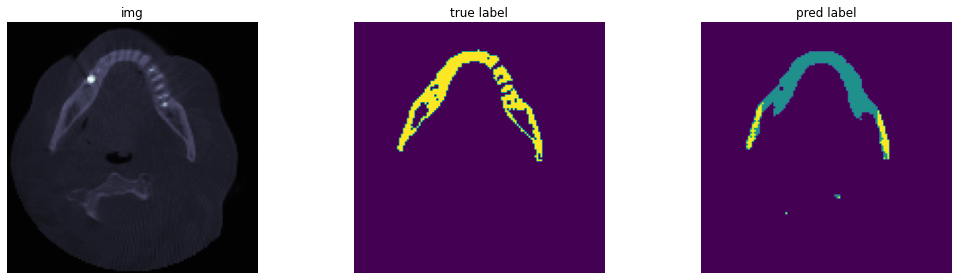

In [ ]:
plot_test_sample(nets_dict=nets_dict, plane='axial', test_loaders=test_loaders)

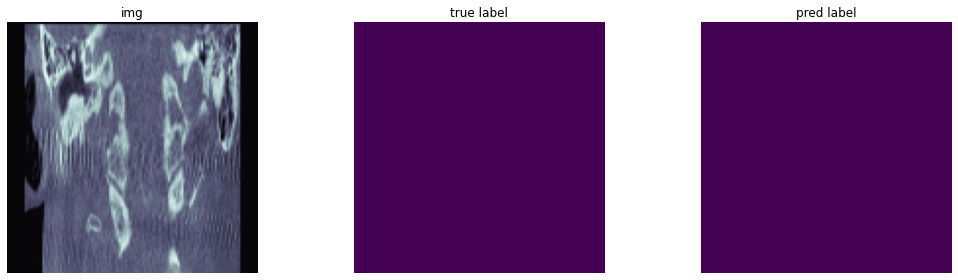

In [ ]:
plot_test_sample(nets_dict=nets_dict, plane='coronal', test_loaders=test_loaders)

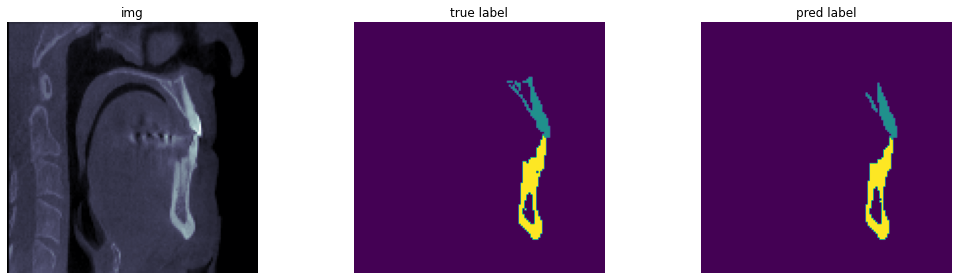

In [ ]:
plot_test_sample(nets_dict=nets_dict, plane='sagittal', test_loaders=test_loaders)